In [ ]:
import pandas as pd
import re

# **Этап 1. Подготовка dataframe к атрибутному анализу**

### Таблицы 'Прайс ЗПУ'

In [ ]:
file_list = [
    '03.04.2025.xlsx', '04.02.2025.xlsx',
    '04.06.2024.xlsx','07.08.2024.xlsx',
    '09.09.2024.xlsx', '09.12.2024.xlsx',
    '12.11.2024.xlsx', '13.05.2025.xlsx'
    ]

In [ ]:
columns_rename = { 'Товар': 'Основное обозначение', 'В наличии на складе': 'Количество',
                  'Цена продажная с НДС': 'Цена', 'Вес': 'Вес штука'}
types = {'Основное обозначение': 'str', 'Еврообозначение': 'str',
    'Код': 'str', 'Вес штука': 'float', 'Количество': 'float', 'Цена': 'float',
    'Название компании': 'str', 'Зарезервировано':'float'}
keep_columns = [
    'Основное обозначение', 'Еврообозначение', 'Код', 'Вес штука',
    'Количество', 'Цена', 'Дата прайса', 'Название компании'
]
company_name = 'ЗПУ'

In [ ]:
def concat_price_files(
    file_list,
    columns_rename=None,
    types=None,
    company_name='',
    output_file='concat.xlsx',
    keep_columns=None
):
    import pandas as pd
    import re

    dfs = []
    for filename in file_list:
        match = re.findall(r'\d{2}\.\d{2}\.\d{4}', filename)
        if match:
            date_str = match[0]
            date_dt = pd.to_datetime(date_str, dayfirst=True)
        else:
            date_dt = pd.NaT

        df = pd.read_excel(filename)

        if columns_rename is not None:
            df = df.rename(columns=columns_rename)

        df['Дата прайса'] = date_dt
        df['Название компании'] = company_name

        if types is not None:
            for col, typ in types.items():
                if col in df.columns:
                    df[col] = df[col].astype(typ)

        df = df.dropna(subset=['Основное обозначение', 'Цена'])
        df = df.drop_duplicates(subset=['Основное обозначение'])

        dfs.append(df)

    # Объединяем все DataFrame
    result_df = pd.concat(dfs, ignore_index=True)

    # Оставляем только нужные столбцы
    if keep_columns is not None:
        result_df = result_df.loc[:, [col for col in keep_columns if col in result_df.columns]]

    # Сохраняем итоговый файл
    result_df.to_excel(output_file, index=False)

    return result_df

In [ ]:
concat_price_files(
    file_list,
    columns_rename=columns_rename,
    types=types,
    company_name=company_name,
    output_file='result.xlsx',
    keep_columns=keep_columns
)

## Таблица 'Себестоимость ЗПУ'

In [ ]:
df = pd.read_excel('Себестоимость по Изменению цен.xlsx', sheet_name='Лист1')
df

In [ ]:
df.columns

In [ ]:
file_list = ['Себестоимость по Изменению цен.xlsx']
types = {
    'Основное обозначение': 'str', 'Модификация': 'str', 'Еврообозначение': 'str',
    'Размер': 'str', 'Количество роликов': 'str', 'Зазор мкм': 'str',
    'BRAND': 'str', 'Вес штука': 'str', 'Вес контракт': 'str',
    'Количество в контракте': 'str', 'Цена по ФОБ в долларах': 'float',
    'Контракт/ Склад': 'str', 'Себестоимость': 'float', 'Цена': 'float',
    '№ контракта': 'str'
}
keep_columns = [
    'Основное обозначение', 'Модификация', 'Еврообозначение', 'Размер',
    'Количество роликов', 'Зазор мкм', 'BRAND', 'Вес штука',
    'Вес контракт', 'Количество в контракте', 'Цена по ФОБ в долларах',
    'Себестоимость', 'Цена', '№ контракта', 'Контракт/ Склад'
]
columns_rename = {
    'GOST': 'Основное обозначение',
    'mod': 'Модификация',
    'size': 'Размер',
    'q-ty roll/bal': 'Количество роликов',
    'clearance': 'Зазор мкм',
    'wheight': 'Вес штука',
    'Total wheight': 'Вес контракт',
    'Q-TY': 'Количество в контракте',
    '1.95-2.5 %': 'Цена по ФОБ в долларах',
    'Контракт/ Склад ': 'Контракт/ Склад',
    'remark': 'Дата запуска контракта',
    'ISO': 'Еврообозначение',
}

In [ ]:
def clean_excel_files(file_list, types, date_cols=None, columns_to_keep=None, columns_rename=None, out_folder="processed"):
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    processed_files = []
    for file_path in file_list:
        df = pd.read_excel(file_path)

        # Переименовываем столбцы
        if columns_rename is not None:
            df = df.rename(columns=columns_rename)

        # Сохраняем релевантные
        if columns_to_keep is not None:
            df = df[columns_to_keep]

        # Преобразовываем типы столбцов
        if types is not None:
            for col, typ in types.items():
                if col in df.columns:
                    df[col] = df[col].astype(typ)

        # Разделяем на две даты из столбца 'Контракт/ Склад'
        if 'Контракт/ Склад' in df.columns:
            dates_split = df['Контракт/ Склад'].str.split('/', expand=True)
            df['Запуск контракта'] = pd.to_datetime(dates_split[0], errors='coerce', dayfirst=True)
            if dates_split.shape[1] > 1:
                df['Поступление на склад'] = pd.to_datetime(dates_split[1], errors='coerce', dayfirst=True)
            else:
                df['Поступление на склад'] = pd.NaT

        # Преобразовываем даты из списка date_cols
        if date_cols is not None:
            for date_col in date_cols:
                if date_col in df.columns:
                    # Здесь для безопасности укажем dayfirst=True
                    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)

        out_file = os.path.join(out_folder, f"processed_{os.path.basename(file_path)}")
        df.to_excel(out_file, index=False)
        processed_files.append(out_file)
    return processed_files

In [ ]:
processed = clean_excel_files(
    file_list, types, date_cols=date_columns,
    columns_to_keep=keep_columns, columns_rename=columns_rename
)

## Таблица 'Прайс Конкуренты'

In [ ]:
#Конкурент 1: ИПК
file_list = ['2024.06.13 ИПК.xlsx', '2024.07.30 ИПК.xlsx',
 '2024.07.12 ИПК.xlsx','2024.08.16 ИПК.xlsx',
 '2024.08.27 ИПК.xlsx', '2024.09.24 ИПК.xlsx',
 '2024.10.10 ИПК.xlsx', '2024.10.28 ИПК.xlsx',
 '2024.11.13 ИПК.xlsx', '2024.12.03 ИПК.xlsx',
 '2024.12.12 ИПК.xlsx', '2025.01.13 ИПК.xlsx',
 '2025.02.04 ИПК.xlsx', '2025.02.17 ИПК.xlsx',
 '2025.03.03 ИПК.xlsx', '2025.03.12 ИПК.xlsx',
 '2025.03.31 ИПК.xlsx', '2025.04.11 ИПК.xlsx',
 '2025.04.30 ИПК.xlsx', '2025.05.15 ИПК.xlsx',
 '2025.06.02 ИПК.xlsx', '2025.06.09 ИПК.xlsx',
 '2025.06.30 ИПК.xlsx']

In [ ]:
#Конкурент 2: Арекон
file_list = ['2024.06.04 Арекон.xlsx', '2024.08.06 Арекон.xlsx',
 '2024.09.06 Арекон.xlsx','2024.10.07 Арекон.xlsx',
 '2024.10.28 Арекон.xlsx', '2024.11.11 Арекон.xlsx',
 '2024.12.09 Арекон.xlsx', '2025.01.14 Арекон.xlsx',
 '2025.02.04 Арекон.xlsx', '2025.02.21 Арекон.xlsx',
 '2025.04.01 Арекон.xlsx', '2025.04.03 Арекон.xlsx',
 '2025.05.13 Арекон.xlsx', '2025.07.21 Арекон.xlsx']

In [ ]:
#Конкурент 3: Азимут
file_list = ['2025.02.11 Азимут.xlsx', '2025.02.20 Азимут.xlsx',
 '2025.03.12 Азимут.xlsx', '2025.03.18 Азимут.xlsx',
 '2025.04.07 Азимут.xlsx', '2025.05.14 Азимут.xlsx',
 '2025.06.02 Азимут.xlsx', '2025.06.06 Азимут.xlsx',
 '2025.07.02 Азимут.xlsx', '2025.07.21 Азимут.xlsx',
 '2025.07.22 Азимут.xlsx']

In [ ]:
#Конкурент 4: ПВ Групп
file_list = ['2023.05.23 Холд.xlsx', '2023.05.26 Холд.xlsx',
 '2023.06.07 Холд.xlsx', '2023.06.26 Холд.xlsx',
 '2023.07.14 Холд.xlsx', '2023.08.10 Холд.xlsx',
 '2023.08.31 Холд.xlsx', '2023.09.13 Холд.xlsx',
 '2023.09.25 Холд.xlsx', '2023.10.11 ПВ Групп.xlsx',
 '2023.11.02 ПВ Групп.xlsx', '2023.11.09 ПВ Групп.xlsx',
 '2023.11.22 ПВ Групп.xlsx', '2023.12.18 ПВ Групп.xlsx',
 '2023.12.29 ПВ Групп.xlsx', '2024.01.10 ПВ Групп.xlsx',
 '2024.04.26 ПВ Групп.xlsx', '2024.05.27 ПВ Групп.xlsx',
 '2024.07.03 ПВ Групп.xlsx', '2024.10.01 ПВ Групп.xlsx',
 '2024.10.15 ПВ Групп.xlsx', '2024.11.02 ПВ Групп.xlsx',
 '2024.11.18 ПВ Групп.xlsx', '2024.12.03 ПВ Групп.xlsx',
 '2024.12.16 ПВ Групп.xlsx', '2025.01.09 ПВ Групп.xlsx',
 '2025.01.15 ПВ Групп.xlsx', '2025.02.04 ПВ Групп.xlsx',
 '2025.02.17 ПВ Групп.xlsx', '2025.03.04 ПВ Групп.xlsx',
 '2025.03.17 ПВ Групп.xlsx', '2025.04.02 ПВ Групп.xlsx',
 '2025.04.14 ПВ Групп.xlsx', '2025.05.06 ПВ Групп.xlsx',
 '2025.05.15 ПВ Групп.xlsx', '2025.06.02 ПВ Групп.xlsx',
 '2025.06.16 ПВ Групп.xlsx', '2025.07.02 ПВ Групп.xlsx',
 '2025.07.21 ПВ Групп.xlsx', '2025.08.04 ПВ Групп.xlsx']

In [ ]:
file_list = ['merged__Арекон.xlsx', 'merged__ИПК.xlsx', 'merged__Азимут.xlsx', 'merged__ПВ Групп.xlsx']
types = {'Бренд': 'str', 'Основное обозначение': 'str', 'Дата прайса': 'str',
         'Примечание': 'str', 'Количество': 'float', 'Цена': 'float',
         'Название компании': 'str'}
date_columns = ['Дата прайса']

In [ ]:
def clean_excel_files(
    file_list,
    types,
    date_cols=None,
    out_folder="processed",
    save_merged=False,
    merged_filename="merged.xlsx"
):
    # Создаем папку для сохранения
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    processed_files = []
    merged_dfs = []

    for file_path in file_list:
        df = pd.read_excel(file_path)

        # Преобразовываем типы столбцов
        for col, typ in types.items():
            if col in df.columns:
                df[col] = df[col].astype(typ)

        # Преобразовываем даты
        if date_cols is not None:
            for date_col in date_cols:
                if date_col in df.columns:
                    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

        out_file = os.path.join(out_folder, f"processed_{os.path.basename(file_path)}")
        df.to_excel(out_file, index=False)
        processed_files.append(out_file)
        merged_dfs.append(df)


    # Объединяем все обработанные данные
    if save_merged and merged_dfs:
        merged_df = pd.concat(merged_dfs, ignore_index=True)
        merged_path = os.path.join(out_folder, merged_filename)
        merged_df.to_excel(merged_path, index=False)
        processed_files.append(merged_path)
    return processed_files

In [ ]:
processed = clean_excel_files(
     file_list, types, date_cols=date_columns,
     save_merged=True
 )
print("Processed files:", processed)

# **Этап 2. Подготовка dataframe к Merge**

## Прайс ЗПУ

In [ ]:
df = pd.read_excel('Общая_ЗПУ.xlsx')

In [ ]:
df.columns

Index(['Основное обозначение', 'Вес штука', 'Количество', 'Цена',
       'Дата прайса'],
      dtype='object')

In [ ]:
df['Основное обозначение_NEW'] = df['Основное обозначение'].astype(str).str.split(' ').str[0]

In [ ]:
df

,Основное обозначение,Вес штука,Количество,Цена,Дата прайса,Основное обозначение_NEW
0,втулка AH2334 FBC (ГОСТ),5,14,5700,2025-04-03,втулка
1,втулка AH2336 MPZ,6,6,3700,2025-04-03,втулка
2,втулка AH2338,7,2,3200,2025-04-03,втулка
3,втулка AH24124 FBC (ГОСТ),1,3,4700,2025-04-03,втулка
4,втулка AH24130 FBC (ГОСТ),5,2,5900,2025-04-03,втулка
...,...,...,...,...,...,...
48915,YEL206-2F,0,90,370,2025-05-13,YEL206-2F
48916,YEL207-2F,1,90,498,2025-05-13,YEL207-2F
48917,YEL208-2F,1,90,670,2025-05-13,YEL208-2F
48918,YEL209-2F,1,90,730,2025-05-13,YEL209-2F


In [ ]:
df.to_excel('Общая_ЗПУ1.xlsx', index=False)

## Себестоиомсть

In [ ]:
df = pd.read_excel('Себестоимость.xlsx')

In [ ]:
df.columns

Index(['Основное обозначение', 'Размер', 'Количество роликов', 'Зазор мкм',
       'BRAND', 'Вес штука', 'Вес контракт', 'Количество в контракте',
       'Цена по ФОБ в долларах', 'Поступление на склад'],
      dtype='object')

In [ ]:
df['Основное обозначение_NEW'] = df['Основное обозначение'].astype(str).str.split(' ').str[0]

In [ ]:
df

,Основное обозначение,Размер,Количество роликов,Зазор мкм,BRAND,Вес штука,Вес контракт,Количество в контракте,Цена по ФОБ в долларах,Поступление на склад,Основное обозначение_NEW
0,100,10х26х8,7,2-13,FBC-GROUP,0,400,20000,0.128428,2024-04-17,100
1,101,12х28х8,8,3-18,FBC-GROUP,0,440,20000,0.132782,2024-04-17,101
2,104,20х42х12,9,5-20,FBC-GROUP,0,1400,20000,0.264148,2024-02-15,104
3,104,20х42х12,9,5-20,TimCo,0,3,40,1.323095,2024-04-10,104
4,104,20х42х12,9,5-20,TimCo,0,73,960,1.267331,2024-08-26,104
...,...,...,...,...,...,...,...,...,...,...,...
4552,ШСП 60,60х90х34/44,0,NaN,NTL,1,990,1000,3.183148,2025-05-06,ШСП
4553,ШСП 70,70х105х40/49,0,NaN,NTL,2,775,500,4.750057,2024-11-21,ШСП
4554,ШСП 70,70х105х40/49,0,NaN,NTL,2,1085,700,4.750057,2024-11-21,ШСП
4555,ШСП 70,70х105х40/49,0,NaN,NTL,2,1550,1000,4.650878,2025-06-26,ШСП


In [ ]:
df.to_excel('Себестоимость1.xlsx', index=False)

## Прайс Конкуренты

In [ ]:
df = pd.read_excel('Общая_конкуренты.xlsx')

In [ ]:
df.columns

Index(['Основное обозначение', 'Количество', 'Цена', 'Дата прайса',
       'Название компании', 'Город'],
      dtype='object')

In [ ]:
df['Основное обозначение_NEW'] = df['Основное обозначение'].astype(str).str.split(' ').str[0]

In [ ]:
df

,Основное обозначение,Количество,Цена,Дата прайса,Название компании,Город,Основное обозначение_NEW
0,35,26,2239,2024-06-03,Арекон,Барнаул,35
1,93,281,19,2024-06-03,Арекон,Барнаул,93
2,106,11,73,2024-06-03,Арекон,Барнаул,106
3,113,5,179,2024-06-03,Арекон,Барнаул,113
4,115,3,254,2024-06-03,Арекон,Барнаул,115
...,...,...,...,...,...,...,...
555448,ШСП45,825,318,2025-08-01,ПВ ГРУПП,Саратов,ШСП45
555449,ШСП50,27594,217,2025-08-01,ПВ ГРУПП,Саратов,ШСП50
555450,ШСП55,3254,389,2025-08-01,ПВ ГРУПП,Саратов,ШСП55
555451,ШСП8,31639,49,2025-08-01,ПВ ГРУПП,Саратов,ШСП8


In [ ]:
df.to_excel('Общая_конкуренты1.xlsx', index=False)

# **Этап 3. Merge Таблиц**

In [ ]:
df1 = pd.read_excel('Общая_ЗПУ1.xlsx')
df2 = pd.read_excel('Общая_конкуренты1.xlsx')

In [ ]:
df3 = pd.read_excel('Себестоимость1.xlsx')

In [ ]:
df4 = pd.read_excel('Курс валют.xlsx')

In [ ]:
df1.columns

Index(['Основное обозначение', 'Вес штука', 'Количество', 'Цена',
       'Дата прайса', 'Основное обозначение_NEW'],
      dtype='object')

In [ ]:
df2.columns

Index(['Основное обозначение', 'Количество', 'Цена', 'Дата прайса',
       'Название компании', 'Город', 'Основное обозначение_NEW'],
      dtype='object')

In [ ]:
df3.columns

Index(['Основное обозначение', 'Модификация', 'Еврообозначение', 'Размер',
       'Количество роликов', 'Зазор мкм', 'BRAND', 'Вес штука', 'Вес контракт',
       'Количество в контракте', 'Цена по ФОБ в долларах', 'Себестоимость',
       'Цена', '№ контракта', 'Запуск контракта', 'Поступление на склад',
       'Основное обозначение_NEW'],
      dtype='object')

In [ ]:
df4.columns

Index(['Дата', 'Юань', 'Доллар США'], dtype='object')

In [ ]:
df1['Месяц'] = pd.to_datetime(df1['Дата прайса']).dt.to_period('M')
df2['Месяц'] = pd.to_datetime(df2['Дата прайса']).dt.to_period('M')

In [ ]:
df3['Месяц'] = pd.to_datetime(df3['Поступление на склад']).dt.to_period('M')

In [ ]:
df4['Месяц'] = pd.to_datetime(df4['Дата']).dt.to_period('M')

In [ ]:
monthly_avg = df4.groupby('Месяц').agg({
    'Юань': 'mean',
    'Доллар США': 'mean'
}).rename(columns={
    'Юань': 'Средний курс Юань',
    'Доллар США': 'Средний курс Доллар США'
}).reset_index()

In [ ]:
merged_df = pd.merge(
    df1,
    df2,
    on=['Основное обозначение_NEW','Месяц'],
    how='inner',
    suffixes=('_pricezpu', '_pricek')
).drop_duplicates()

In [ ]:
merged_df1 = pd.merge(
    merged_df,
    df3,
    on=['Основное обозначение_NEW','Месяц'],
    how='inner',
    suffixes=('_pricezpu', '_pricek')
).drop_duplicates()

In [ ]:
merged_df2 = pd.merge(
    merged_df1,
    monthly_avg,
    on=['Месяц'],
    how='left',
).drop_duplicates()

In [ ]:
merged_df2.columns

Index(['Вес штука_pricezpu', 'Количество_pricezpu', 'Цена_pricezpu',
       'Дата прайса_pricezpu', 'Основное обозначение_NEW', 'Месяц',
       'Количество_pricek', 'Цена_pricek', 'Дата прайса_pricek',
       'Название компании', 'Город', 'Количество роликов', 'BRAND',
       'Вес контракт', 'Количество в контракте', 'Цена по ФОБ в долларах',
       'Поступление на склад', 'Средний курс Юань', 'Средний курс Доллар США'],
      dtype='object')

In [ ]:
merged_df2 = merged_df2.drop(['Основное обозначение','Основное обозначение_pricezpu', 'Основное обозначение_pricek', 'Размер', 'Зазор мкм', 'Вес штука_pricek', 'Запуск контракта', 'Модификация', 'Еврообозначение','Себестоимость', 'Цена', '№ контракта'], axis=1)

In [ ]:
merged_df2.to_excel('Общая.xlsx', index=False)

# **Этап 4. EDA**

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('Общая.xlsx')

In [3]:
df.describe()

,Вес штука_pricezpu,Количество_pricezpu,Цена_pricezpu,Дата прайса_pricezpu,Количество_pricek,Цена_pricek,Дата прайса_pricek,Количество роликов,Вес контракт,Количество в контракте,Цена по ФОБ в долларах,Поступление на склад,Средний курс Юань,Средний курс Доллар США
count,9346.000000,9346.000000,9346.000000,9346,9346.000000,9346.000000,9346,9346.000000,9346.000000,9346.000000,9346.000000,9346,9346.000000,9346.000000
mean,5.907019,2159.213246,3054.616841,2025-01-17 13:25:49.240316672,3782.317783,3242.036486,2025-01-20 06:00:13.866894848,13.838862,2887.371710,7760.204366,20.293700,2025-01-24 21:07:07.562593536,12.591014,92.049908
min,0.000000,1.000000,4.000000,2024-06-04 00:00:00,0.000000,0.000000,2024-06-03 00:00:00,0.000000,18.000000,6.000000,0.102791,2024-06-25 00:00:00,11.120839,80.293039
25%,0.000000,8.000000,150.000000,2024-12-09 00:00:00,3.000000,233.000000,2024-12-01 00:00:00,8.000000,950.000000,300.000000,0.976313,2024-12-03 00:00:00,11.387932,83.425600
50%,1.000000,170.000000,570.000000,2024-12-09 00:00:00,101.000000,784.000000,2024-12-28 00:00:00,9.000000,1730.000000,1000.000000,3.975824,2024-12-24 00:00:00,12.789155,91.234505
75%,6.000000,1128.000000,2370.000000,2025-04-03 00:00:00,845.000000,2744.000000,2025-04-10 00:00:00,16.000000,3600.000000,6000.000000,18.665830,2025-04-18 00:00:00,13.889810,102.259648
max,246.000000,49990.000000,230000.000000,2025-05-13 00:00:00,544781.000000,226436.000000,2025-05-30 00:00:00,115.000000,22000.000000,100000.000000,1614.331248,2025-05-29 00:00:00,13.895150,102.259648
std,14.428556,5659.274263,7662.507511,NaN,21940.302091,8579.195890,NaN,9.862139,3207.643791,18104.454089,50.125357,NaN,1.232096,9.293044


## **1) Обзор пропусков и базовой статистики**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Основное обозначение_NEW  9346 non-null   object        
 1   Вес штука_pricezpu        9346 non-null   int64         
 2   Количество_pricezpu       9346 non-null   int64         
 3   Цена_pricezpu             9346 non-null   int64         
 4   Дата прайса_pricezpu      9346 non-null   datetime64[ns]
 5   Месяц                     9346 non-null   object        
 6   Количество_pricek         9346 non-null   int64         
 7   Цена_pricek               9346 non-null   int64         
 8   Дата прайса_pricek        9346 non-null   datetime64[ns]
 9   Название компании         9346 non-null   object        
 10  Город                     9346 non-null   object        
 11  Количество роликов        9346 non-null   int64         
 12  BRAND               

In [5]:
COLS = df.columns.tolist()
COLS_NUM = df.select_dtypes(include=[np.number]).columns.tolist()
COLS_OBJ = df.select_dtypes(include=["object"]).columns.tolist()
COLS_DT  = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
print("Размер:", df.shape)
print("Числовые:", COLS_NUM)
print("Категориальные:", COLS_OBJ)
print("Датовые:", COLS_DT)

Размер: (9346, 19)
Числовые: ['Вес штука_pricezpu', 'Количество_pricezpu', 'Цена_pricezpu', 'Количество_pricek', 'Цена_pricek', 'Количество роликов', 'Вес контракт', 'Количество в контракте', 'Цена по ФОБ в долларах', 'Средний курс Юань', 'Средний курс Доллар США']
Категориальные: ['Основное обозначение_NEW', 'Месяц', 'Название компании', 'Город', 'BRAND']
Датовые: ['Дата прайса_pricezpu', 'Дата прайса_pricek', 'Поступление на склад']


In [6]:
miss = df.isna().mean().sort_values(ascending=False)
display(miss.to_frame("Доля_пропусков"))

,Доля_пропусков
Основное обозначение_NEW,0.0
Вес штука_pricezpu,0.0
Количество_pricezpu,0.0
Цена_pricezpu,0.0
Дата прайса_pricezpu,0.0
Месяц,0.0
Количество_pricek,0.0
Цена_pricek,0.0
Дата прайса_pricek,0.0
Название компании,0.0


In [7]:
display(df.describe(include="number").T)
display(df.describe(include="object").T)

,count,mean,std,min,25%,50%,75%,max
Вес штука_pricezpu,9346.0,5.907019,14.428556,0.000000,0.000000,1.000000,6.000000,246.000000
Количество_pricezpu,9346.0,2159.213246,5659.274263,1.000000,8.000000,170.000000,1128.000000,49990.000000
Цена_pricezpu,9346.0,3054.616841,7662.507511,4.000000,150.000000,570.000000,2370.000000,230000.000000
Количество_pricek,9346.0,3782.317783,21940.302091,0.000000,3.000000,101.000000,845.000000,544781.000000
Цена_pricek,9346.0,3242.036486,8579.195890,0.000000,233.000000,784.000000,2744.000000,226436.000000
Количество роликов,9346.0,13.838862,9.862139,0.000000,8.000000,9.000000,16.000000,115.000000
Вес контракт,9346.0,2887.371710,3207.643791,18.000000,950.000000,1730.000000,3600.000000,22000.000000
Количество в контракте,9346.0,7760.204366,18104.454089,6.000000,300.000000,1000.000000,6000.000000,100000.000000
Цена по ФОБ в долларах,9346.0,20.293700,50.125357,0.102791,0.976313,3.975824,18.665830,1614.331248
Средний курс Юань,9346.0,12.591014,1.232096,11.120839,11.387932,12.789155,13.889810,13.895150


,count,unique,top,freq
Основное обозначение_NEW,9346,522,180306,192
Месяц,9346,7,2024-12,3264
Название компании,9346,4,ПВ ГРУПП,4741
Город,9346,4,Саратов,4741
BRAND,9346,6,FBC-GROUP,4106


## **2) Приведение типов и базовая очистка**

**Очистка текстовых: trim + унификация регистра**

In [8]:
for c in ["Основное обозначение_NEW","Название компании","Город","BRAND","Месяц"]:
    if c in df.columns and df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()

**Фича-инжиниринг по датам**

In [9]:
for dc in ["Дата прайса_pricezpu","Дата прайса_pricek","Поступление на склад"]:
    if dc in df.columns and np.issubdtype(df[dc].dtype, np.datetime64):
        df[f"{dc}_ym"]  = df[dc].dt.to_period("M").astype(str)
        df[f"{dc}_year"] = df[dc].dt.year
        df[f"{dc}_month"]= df[dc].dt.month

**Проверка дубликатов**

In [10]:
dups = df.duplicated().sum()
print(f"Дубликатов в строках: {dups}")

Дубликатов в строках: 90


In [11]:
df = df.drop_duplicates()

**Распределение таргета**

In [12]:
target = "Цена_pricezpu"
df = df.copy()
df["log_target"] = np.log1p(df[target])

In [13]:
print(df['Цена_pricezpu'].describe())

count      9256.000000
mean       3047.765341
std        7683.948799
min           4.000000
25%         149.000000
50%         570.000000
75%        2350.000000
max      230000.000000
Name: Цена_pricezpu, dtype: float64


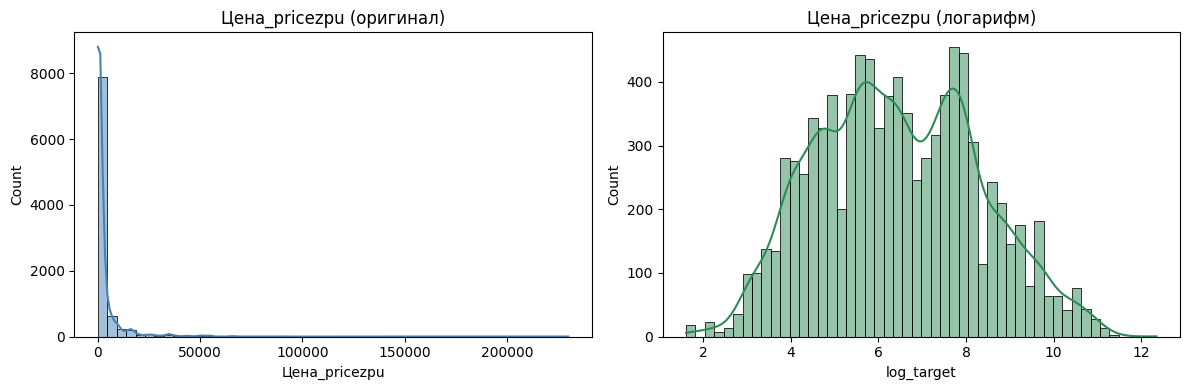

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df[target], bins=50, kde=True, ax=axes[0], color="steelblue")
axes[0].set_title(f"{target} (оригинал)")

sns.histplot(df["log_target"], bins=50, kde=True, ax=axes[1], color="seagreen")
axes[1].set_title(f"{target} (логарифм)")
plt.tight_layout()
plt.show()

In [15]:
bins = [0, 500, 3000, 10000, np.inf]
labels = ['Бюджет', 'Средний', 'Высокий', 'Премиум']
df['price_cluster'] = pd.cut(df['Цена_pricezpu'], bins=bins, labels=labels)
df['price_cluster'].value_counts()

,count
price_cluster,
Бюджет,4408
Средний,2993
Высокий,1195
Премиум,660


In [16]:
df_no_premium = df[df['price_cluster'] != 'Премиум'].copy()

In [17]:
df = df_no_premium.copy()

In [18]:
print(df['Цена_pricezpu'].describe())

count    8596.000000
mean     1384.733481
std      2013.860275
min         4.000000
25%       128.000000
50%       470.000000
75%      1900.000000
max      9866.000000
Name: Цена_pricezpu, dtype: float64


**Связь таргета с числовыми фичами**

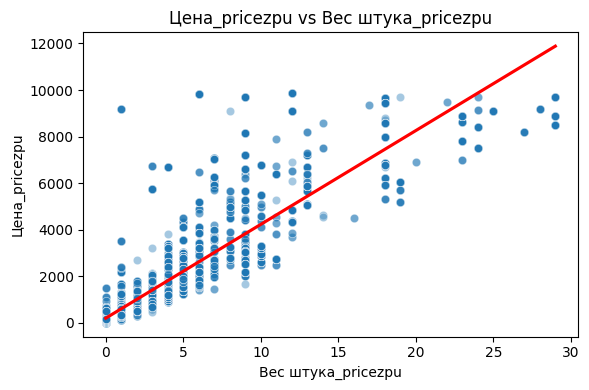

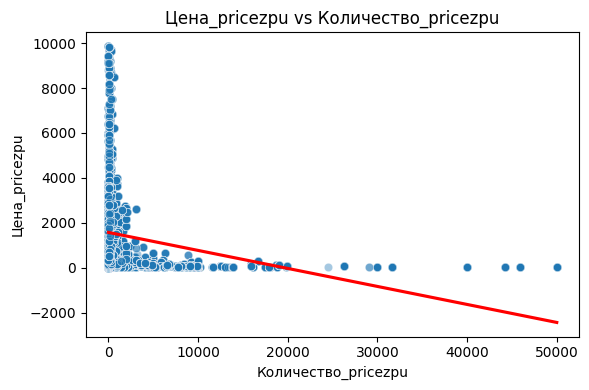

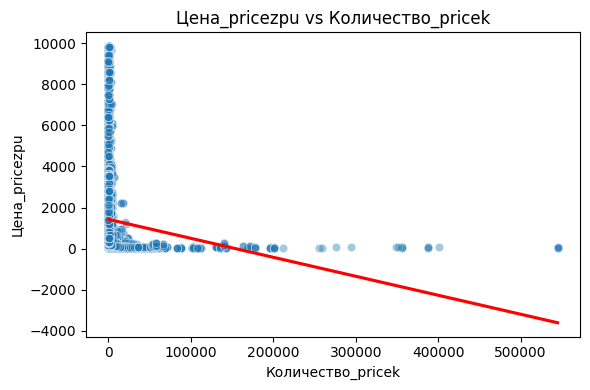

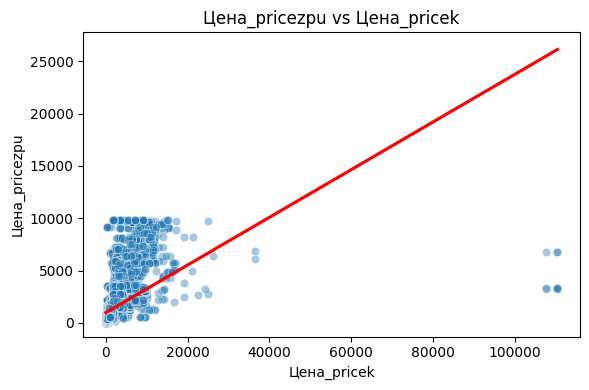

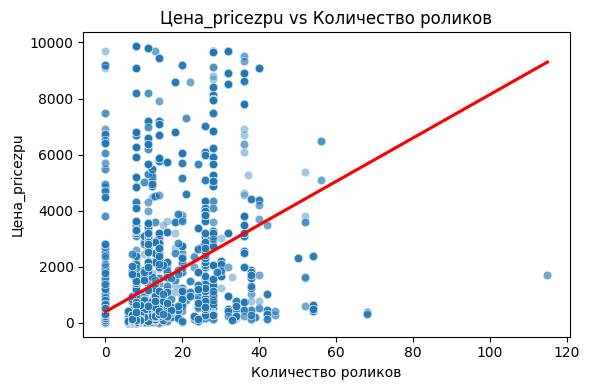

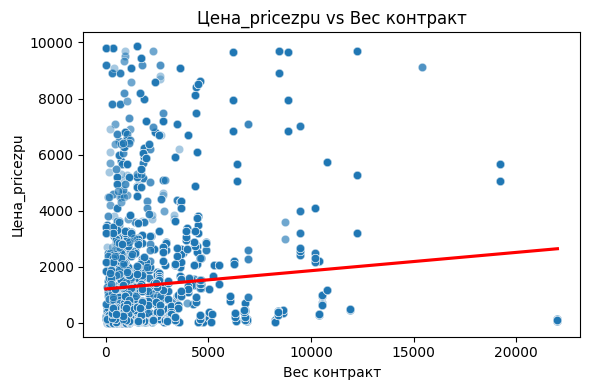

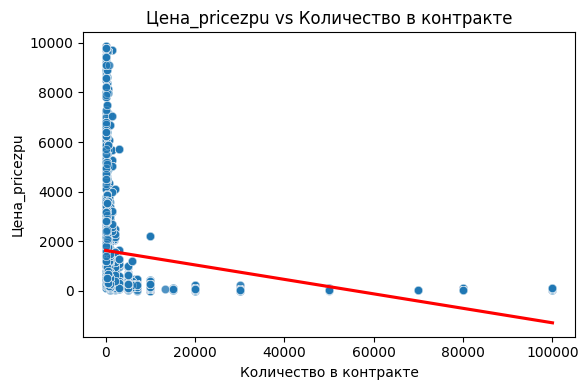

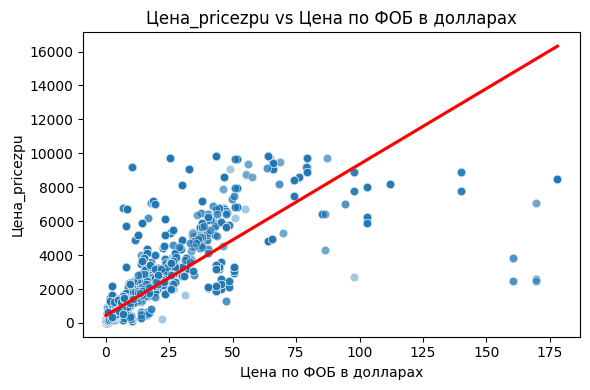

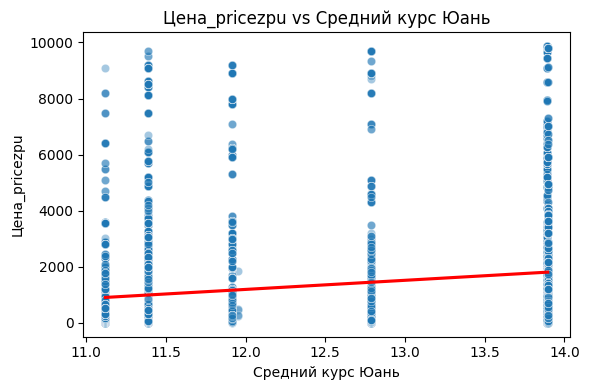

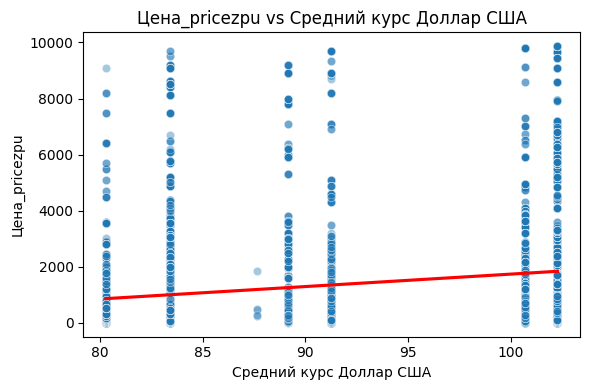

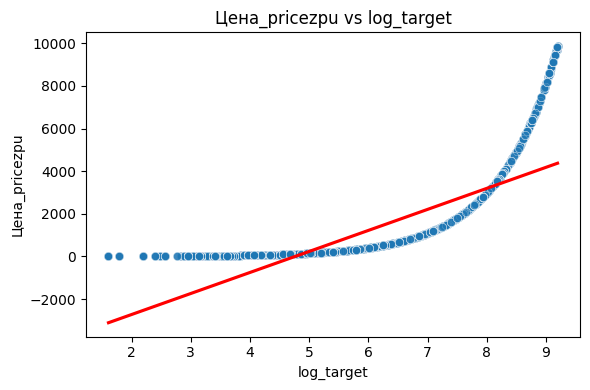

In [19]:
num_features = df.select_dtypes(include=["int64","float64"]).columns.drop(target)

for col in num_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y=target, alpha=0.4)
    sns.regplot(data=df, x=col, y=target, scatter=False, color="red", ci=False)
    plt.title(f"{target} vs {col}")
    plt.tight_layout()
    plt.show()

**Связь таргета с категориальными фичами**

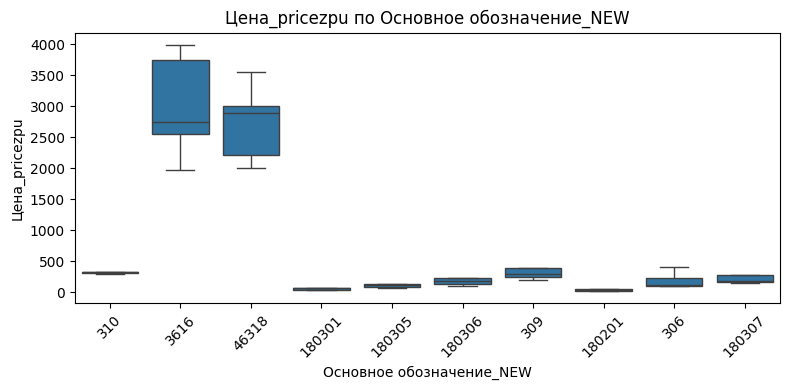

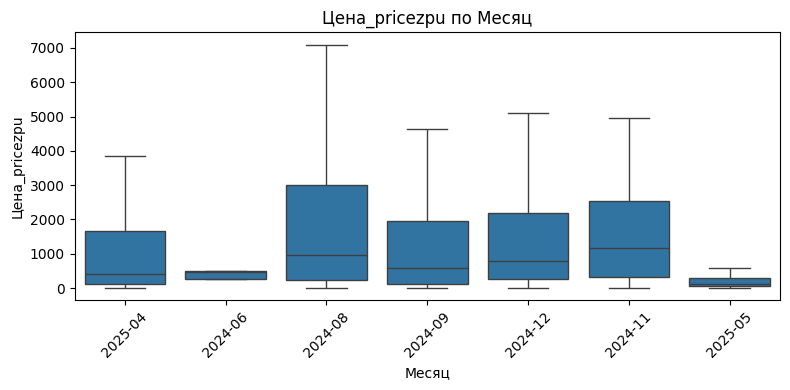

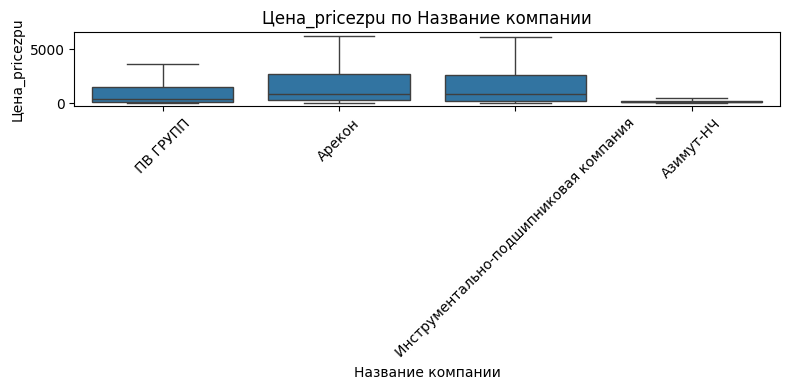

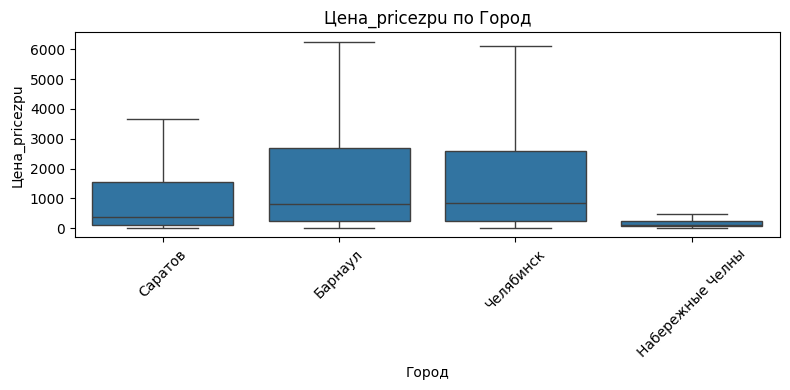

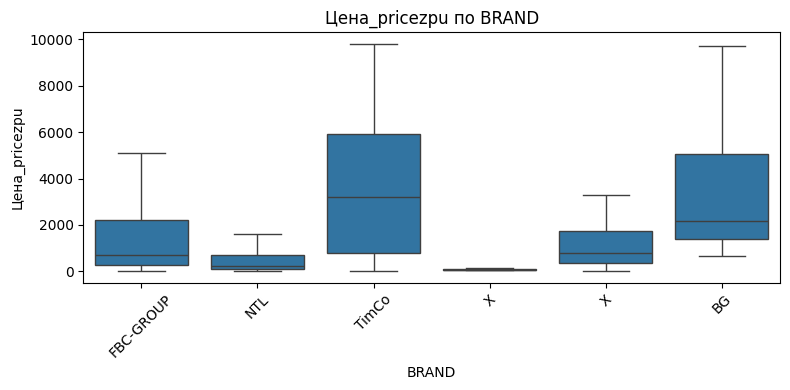

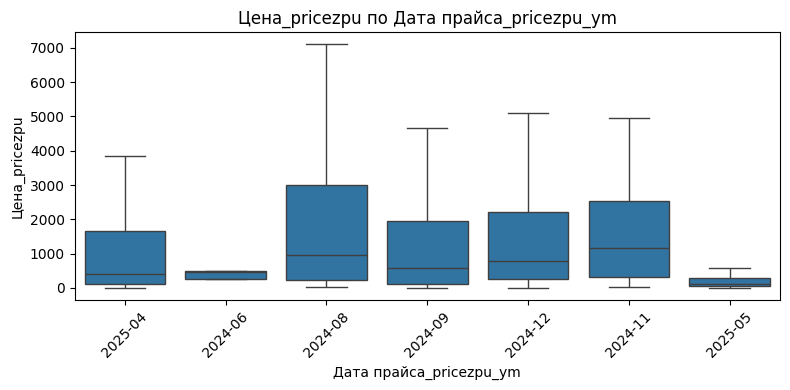

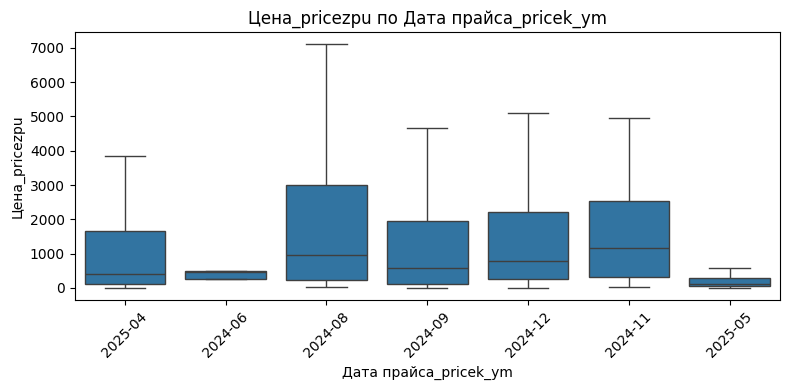

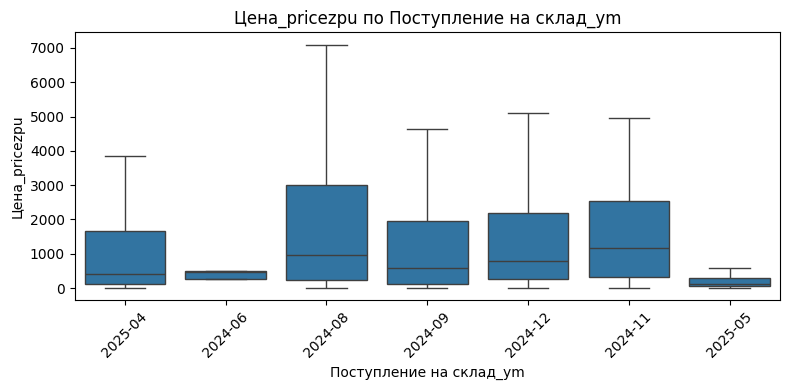

In [20]:
cat_features = df.select_dtypes(include=["object"]).columns

for col in cat_features:
    top_vals = df[col].value_counts().head(10).index
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df[df[col].isin(top_vals)], x=col, y=target, showfliers=False)
    plt.title(f"{target} по {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Корреляции**

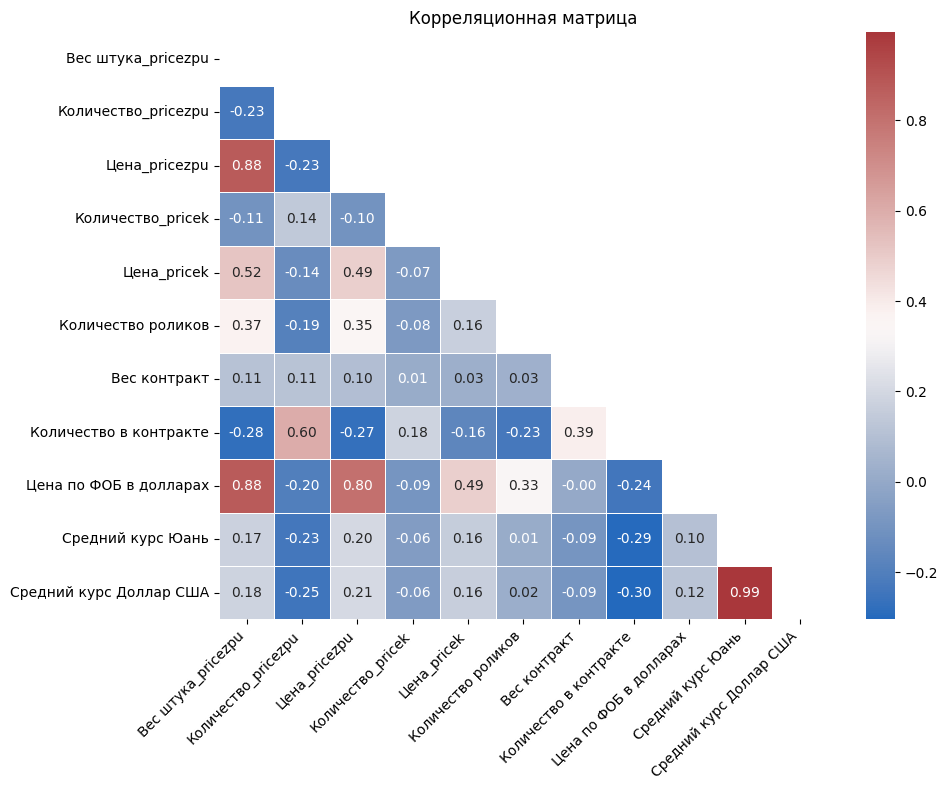

In [21]:
corr_cols = [
    c for c in [
        'Вес штука_pricezpu', 'Количество_pricezpu', 'Цена_pricezpu',
        'Количество_pricek', 'Цена_pricek', 'Количество роликов', 'Вес контракт',
        'Количество в контракте', 'Цена по ФОБ в долларах', 'Средний курс Юань',
        'Средний курс Доллар США'
    ] if c in df.columns
]

if len(corr_cols) >= 2:
    corr = df[corr_cols].corr(numeric_only=True)

    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr, mask=mask, annot=True, fmt=".2f",
        cmap="vlag", linewidths=.5, cbar=True
    )

    plt.title("Корреляционная матрица")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

**Сильные положительные корреляции (>0.8)**

Вес штука_pricezpu ↔ Цена_pricezpu (0.88)
Вес штука_pricezpu ↔ Цена по FOB в долларах (0.88)
Цена_pricezpu ↔ Цена по FOB в долларах (0.8)
Средний курс Юань ↔ Средний курс Доллар США (0.99)

**Умеренные положительные корреляции (0.3–0.6)**

Количество в контракте ↔ Количество_pricezpu (0.6) — логично: чем больше заявлено в контракте, тем выше учтённое количество.

Количество роликов ↔ Цена_pricezpu (0.35) — партии с большим количеством роликов ассоциированы с более высокой ценой (крупные партии или дорогие изделия).

**Поиск выбросов (простая эвристика через IQR)**

[Выбросы] Цена_pricezpu: пороги [-2530.00, 4558.00], доля выбросов = 8.4%


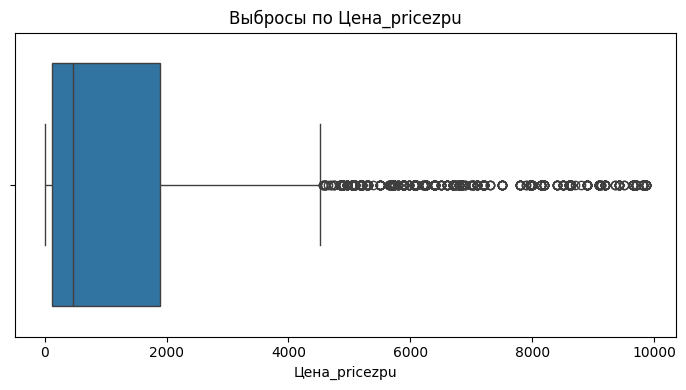

[Выбросы] Цена_pricek: пороги [-2823.00, 5265.00], доля выбросов = 8.4%


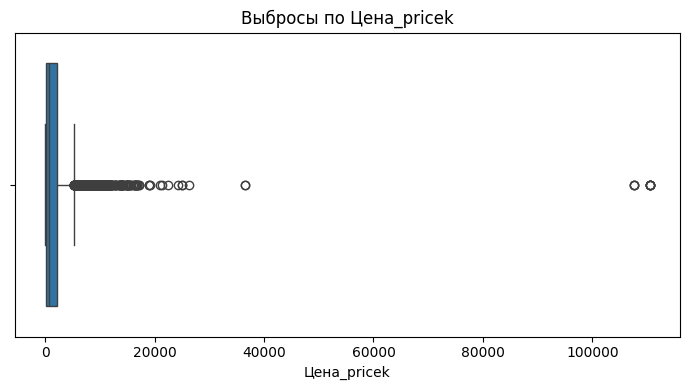

[Выбросы] Цена по ФОБ в долларах: пороги [-18.44, 33.18], доля выбросов = 9.0%


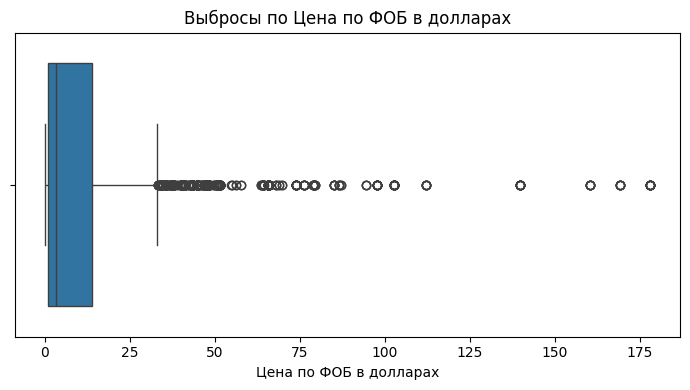

In [22]:
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return low, high

for c in ["Цена_pricezpu","Цена_pricek","Цена по ФОБ в долларах"]:
    if c in df.columns:
        low, high = iqr_outliers(df[c].dropna())
        out_rate = ((df[c] < low) | (df[c] > high)).mean()
        print(f"[Выбросы] {c}: пороги [{low:.2f}, {high:.2f}], доля выбросов = {out_rate:.1%}")

        plt.figure(figsize=(7,4))
        sns.boxplot(x=df[c], showfliers=True)
        plt.title(f"Выбросы по {c}")
        plt.tight_layout()
        plt.show()

**Удаление выбросов по z-score**

In [23]:
from scipy.stats import zscore

Размер до: (8596, 30)
Размер после (без выбросов): (8596, 30)


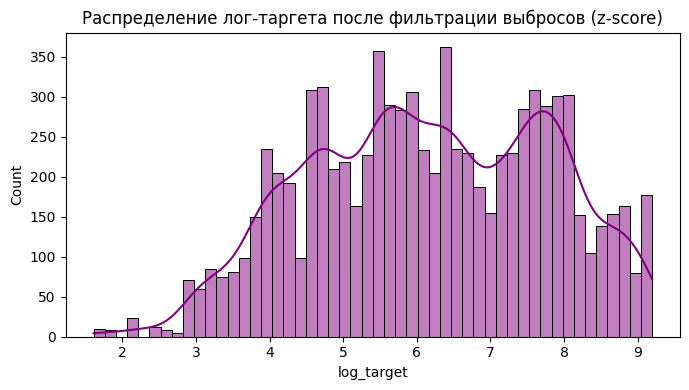

In [24]:
z_scores = zscore(df["log_target"].dropna())
mask = np.abs(z_scores) < 3
df_clean = df.loc[mask]

print("Размер до:", df.shape)
print("Размер после (без выбросов):", df_clean.shape)

# Проверка распределения после очистки
plt.figure(figsize=(7,4))
sns.histplot(df_clean["log_target"], bins=50, kde=True, color="purple")
plt.title("Распределение лог-таргета после фильтрации выбросов (z-score)")
plt.tight_layout()
plt.show()

**Сезонность**

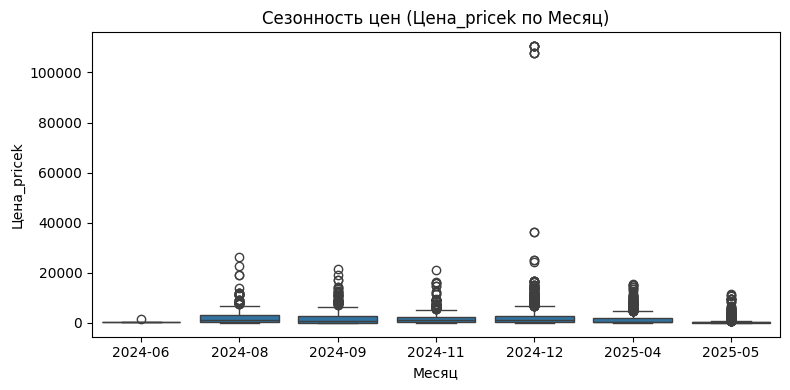

In [25]:
if "Месяц" in df.columns and "Цена_pricek" in df.columns:
    order_months = [str(m) for m in range(1,13)]
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x="Месяц", y="Цена_pricek", order=sorted(df["Месяц"].unique(), key=lambda s: int(re.sub(r'\D','',s)) if re.search(r'\d', s or '') else 99))
    plt.title("Сезонность цен (Цена_pricek по Месяц)")
    plt.tight_layout()
    plt.show()

**Определяем и заполняем нулевые и пустые поля**

In [26]:
checks = {}

# Нулевые или отрицательные цены/веса/кол-ва
for c in ["Цена_pricezpu","Цена_pricek","Цена по ФОБ в долларах","Вес штука_pricezpu","Вес контракт",
          "Количество_pricezpu","Количество_pricek","Количество роликов","Количество в контракте"]:
    if c in df.columns:
        checks[f"{c}<=0"] = int((df[c] <= 0).sum())

# Пустые ключевые поля
for c in ["Основное обозначение_NEW","BRAND","Название компании","Город"]:
    if c in df.columns:
        checks[f"missing_{c}"] = int(df[c].isna().sum() + (df[c].astype(str).str.strip()=="").sum())

quality_report = pd.Series(checks).sort_index()
display(quality_report.rename("issues_count"))


,issues_count
missing_BRAND,0
missing_Город,0
missing_Название компании,0
missing_Основное обозначение_NEW,0
Вес контракт<=0,0
Вес штука_pricezpu<=0,3045
Количество в контракте<=0,0
Количество роликов<=0,306
Количество_pricek<=0,1483
Количество_pricezpu<=0,0


In [27]:
df = df.copy()

In [28]:
num_cols = [
    "Вес штука_pricezpu","Количество_pricek","Количество роликов","Цена_pricek"
]

for col in num_cols:
    if col in df.columns:
        # 1) заменяем нули на NaN
        df[col] = df[col].replace(0, np.nan)
        # 2) считаем среднее по столбцу (без NaN)
        mean_val = df[col].mean(skipna=True)
        # 3) заполняем NaN средним
        df[col] = df[col].fillna(mean_val)

        print(f"{col}: заполнено средним ({mean_val:.2f})")

Вес штука_pricezpu: заполнено средним (4.55)
Количество_pricek: заполнено средним (4942.04)
Количество роликов: заполнено средним (13.17)
Цена_pricek: заполнено средним (1828.29)


**Target Encoding**

In [29]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, train_test_split

In [30]:
target = "Цена_pricezpu"
cat_cols = df.select_dtypes(include="object").columns.tolist()
df_encoded = df.copy()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for col in cat_cols:
    n_unique = df[col].nunique()
    if n_unique <= 30:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
        print(f"{col}: one-hot encoding ({n_unique})")
    else:
        # --- Target Encoding (Out-of-Fold) ---
        oof_target = pd.Series(np.nan, index=df.index)
        for train_idx, val_idx in kf.split(df):
            train, val = df.iloc[train_idx], df.iloc[val_idx]
            means = train.groupby(col)[target].mean()
            oof_target.iloc[val_idx] = val[col].map(means)
        global_mean = df[target].mean()
        oof_target = oof_target.fillna(global_mean)
        df_encoded[col + "_te"] = oof_target
        df_encoded = df_encoded.drop(columns=[col])
        print(f"{col}: target encoding ({n_unique})")

df_encoded["log_target"] = np.log1p(df_encoded[target])
print("Размер после кодирования:", df_encoded.shape)

Основное обозначение_NEW: target encoding (490)
Месяц: one-hot encoding (7)
Название компании: one-hot encoding (4)
Город: one-hot encoding (4)
BRAND: one-hot encoding (6)
Дата прайса_pricezpu_ym: one-hot encoding (7)
Дата прайса_pricek_ym: one-hot encoding (7)
Поступление на склад_ym: one-hot encoding (7)
Размер после кодирования: (8596, 58)


In [31]:
check = df.assign(te=oof_target).groupby("Основное обозначение_NEW").agg(
    mean_target=("Цена_pricezpu","mean"),
    mean_te=("te","mean"),
    freq=("Цена_pricezpu","size")
).reset_index()

In [32]:
corr = check["mean_target"].corr(check["mean_te"])
print("Корреляция между target encoding и средним таргетом:", round(corr, 4))

Корреляция между target encoding и средним таргетом: 0.9383


# **Этап 5. Построение моделей**

In [33]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

**OLS модель**

In [34]:
date_cols = [col for col in df_encoded.columns if "Дата" in col or "Поступление" in col]
exclude_cols = [target, "log_target"] + date_cols

In [35]:
X = df_encoded.drop(columns=exclude_cols, errors="ignore").copy()
X = X.select_dtypes(include=[np.number]).copy()
y = df_encoded[target].astype(float)

In [36]:
for col in X.select_dtypes(include="bool").columns:
    X[col] = X[col].astype(int)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

In [40]:
ols_base = sm.OLS(y_train, X_train_const).fit()

In [47]:
y_pred_train = ols_base.predict(X_train_const)
y_pred_test  = ols_base.predict(X_test_const)

In [48]:
r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
mape_test  = mean_absolute_percentage_error(y_test, y_pred_test) * 100

In [49]:
print("\n=== OLS Regression: Результаты ===")
print(f"R² (train): {r2_train:.4f}")
print(f"R² (test) : {r2_test:.4f}")
print(f"MSE (train): {mse_train:,.2f}")
print(f"MSE (test) : {mse_test:,.2f}")
print(f"RMSE (train): {rmse_train:,.2f}")
print(f"RMSE (test): {rmse_test:,.2f}")
print(f"MAPE (train): {mape_train:.2f}%")
print(f"MAPE (test): {mape_test:.2f}%")


=== OLS Regression: Результаты ===
R² (train): 0.8479
R² (test) : 0.8702
MSE (train): 616,678.61
MSE (test) : 526,014.64
RMSE (train): 785.29
RMSE (test): 725.27
MAPE (train): 68.33%
MAPE (test): 65.18%


**Проверка мультиколлинеарности (VIF)**

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [51]:
# 1. Расчёт VIF
X_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\n=== Проверка мультиколлинеарности ===")
print(vif_data.sort_values("VIF", ascending=False))


=== Проверка мультиколлинеарности ===
                        feature         VIF
0                         const  145.378473
10      Средний курс Доллар США   97.901204
9             Средний курс Юань   97.562917
11  Основное обозначение_NEW_te    6.090702
8        Цена по ФОБ в долларах    4.386708
1            Вес штука_pricezpu    3.469361
7        Количество в контракте    2.219108
2           Количество_pricezpu    1.638775
4                   Цена_pricek    1.409837
6                  Вес контракт    1.333311
5            Количество роликов    1.267927
3             Количество_pricek    1.038842


In [52]:
#2. Удаление признаков с inf или VIF > 10
to_drop = vif_data[(~np.isfinite(vif_data["VIF"])) | (vif_data["VIF"] > 10)]["feature"].tolist()
if "const" in to_drop:
    to_drop.remove("const")

print(f"Удаляем признаки с VIF > 10 или inf: {len(to_drop)}")
print(to_drop)

Удаляем признаки с VIF > 10 или inf: 2
['Средний курс Юань', 'Средний курс Доллар США']


In [53]:
X_train_reduced = X_train.drop(columns=to_drop, errors="ignore")
X_test_reduced = X_test.drop(columns=to_drop, errors="ignore")

In [54]:
#3. Новая модель после очистки
X_train_reduced_const = sm.add_constant(X_train_reduced)
ols_reduced = sm.OLS(y_train, X_train_reduced_const).fit()

In [55]:
r2_train_new = r2_score(y_train, ols_reduced.predict(X_train_reduced_const))
r2_test_new = r2_score(y_test, ols_reduced.predict(sm.add_constant(X_test_reduced)))

In [56]:
# 4. Сравнение результатов
compare_df = pd.DataFrame({
    "Метрика": ["R² (train)", "R² (test)", "Количество признаков"],
    "До очистки": [r2_train, r2_test, X_train.shape[1]],
    "После очистки": [r2_train_new, r2_test_new, X_train_reduced.shape[1]],
})
compare_df["Δ"] = compare_df["После очистки"] - compare_df["До очистки"]

print("\n=== Сравнение модели до и после удаления мультиколлинеарных признаков ===")
print(compare_df.to_string(index=False))


=== Сравнение модели до и после удаления мультиколлинеарных признаков ===
             Метрика  До очистки  После очистки         Δ
          R² (train)    0.847943       0.847660 -0.000283
           R² (test)    0.870218       0.870754  0.000536
Количество признаков   11.000000       9.000000 -2.000000


🔹 Нулевая гипотеза (H₀):

Независимые переменные не коррелируют между собой (нет мультиколлинеарности).

🔹 Альтернативная гипотеза (H₁):

Существует линейная зависимость между одной переменной и комбинацией других (есть мультиколлинеарность).

VIF ≈ 1	Полное отсутствие корреляции(Отлично)

VIF 1–5	Умеренная корреляция(Допустимо)

VIF 5–10	Сильная корреляция(Возможная коллинеарность, стоит проверить)

VIF > 10 Мультиколлинеарность(Признак нужно удалить или объединить)

VIF = ∞	Линейно зависим (дубликат)	Ошибка кодирования (дублирование dummy)

**Вывод по тесту:**

H₀ (нет мультиколлинеарности) отклоняется,
т.к. множество признаков имеют VIF = ∞ или > 10.

Это означает, что часть переменных линейно зависима и дублирует информацию.
Для корректной интерпретации коэффициентов OLS и корректности статистических тестов необходимо очистить модель.

**Проверка гетероскедастичности (Breusch-Pagan)**

In [57]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.1 MB/s eta 0:00:00


In [58]:
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.iv import IV2SLS
import numpy as np

In [59]:
bp_test = het_breuschpagan(ols_base.resid, ols_base.model.exog)
labels = ["LM Stat", "LM p-value", "F-Stat", "F p-value"]
bp = dict(zip(labels, bp_test))

print("\n=== Breusch–Pagan Test ===")
print("H₀: ошибки модели гомоскедастичны (σ² = const)")
print("H₁: дисперсия ошибок зависит от регрессоров (гетероскедастичность)")
print(f"LM Stat : {bp['LM Stat']:.3f}")
print(f"LM p-value : {bp['LM p-value']:.5f}")

if bp['LM p-value'] < 0.05:
    print("❌ Отклоняем H₀ — есть гетероскедастичность, используем HC3 ошибки")
else:
    print("✅ Не отклоняем H₀ — гомоскедастичность подтверждена")


=== Breusch–Pagan Test ===
H₀: ошибки модели гомоскедастичны (σ² = const)
H₁: дисперсия ошибок зависит от регрессоров (гетероскедастичность)
LM Stat : 834.699
LM p-value : 0.00000
❌ Отклоняем H₀ — есть гетероскедастичность, используем HC3 ошибки


H₀ (нулевая гипотеза): ошибки имеют постоянную дисперсию (гомоскедастичны).

H₁ (альтернатива): дисперсия ошибок зависит от предикторов (гетероскедастичность присутствует).

Вывод: p ≤ 0.05 → не принимаем H₀ → гетероскедастичность есть.

**Проверка эндогенности (Durbin–Wu–Hausman) и IV-регрессия(Опционально)**

In [60]:
from linearmodels.iv import IV2SLS
import numpy as np

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
# === 1. Обозначим переменные ===
y = y_train.values
X = X_train.drop(columns=["Вес контракт"], errors="ignore")
endog = X_train["Вес контракт"].values.reshape(-1, 1)
instr = X_train["Количество в контракте"].values.reshape(-1, 1)

# === 2. Первый шаг: регрессия эндогенной переменной на инструмент ===
first_stage = LinearRegression().fit(instr, endog)
endog_hat = first_stage.predict(instr)

# === 3. Второй шаг: добавляем остатки в OLS-регрессию ===
# Остатки показывают необъяснённую часть эндогенной переменной
residuals = endog - endog_hat

# Формируем матрицу регрессоров
X2 = np.hstack([X, endog, residuals])
X2 = sm.add_constant(X2)

# Обучаем модель и извлекаем p-value последнего признака (остатков)
model_test = sm.OLS(y, X2).fit()
p_value = model_test.pvalues[-1]

print("\n=== Durbin–Wu–Hausman (упрощённый тест) ===")
print("H₀: переменная экзогенна (OLS состоятельна)")
print("H₁: переменная эндогенна (OLS смещена)")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("❌ Отклоняем H₀ — есть эндогенность, нужна IV-регрессия.")
else:
    print("✅ Не отклоняем H₀ — OLS можно использовать.")


=== Durbin–Wu–Hausman (упрощённый тест) ===
H₀: переменная экзогенна (OLS состоятельна)
H₁: переменная эндогенна (OLS смещена)
P-value: 0.0002
❌ Отклоняем H₀ — есть эндогенность, нужна IV-регрессия.


**Нулевая гипотеза (H₀):**

Эндогенности нет. Оставляем OLS модель.

**Альтернативная гипотеза (H₁):**

Переменная эндогенна. Нужна модель с инструментальными переменными IV-регрессия.

**IV-регрессия**

In [63]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from numpy.linalg import matrix_rank

In [64]:
# Определяем основные переменные
y_iv = y_train
X_iv = X_train.copy()

endog_name = "Вес контракт"
instr_name = "Количество в контракте"

# Исключаем эндогенную и инструментальную из экзогенных
X_exog = X_iv.drop(columns=[endog_name, instr_name], errors="ignore")

In [65]:
# --- Функция удаления мультиколлинеарных признаков ---
def drop_collinear(X, endog):
    """
    Удаляет линейно зависимые признаки из X, пока ранг матрицы [X + endog] не станет полным.
    """
    X_copy = X.copy()
    iteration = 0

    # Выравниваем размеры по количеству строк
    if X_copy.shape[0] != endog.shape[0]:
        min_len = min(X_copy.shape[0], endog.shape[0])
        X_copy = X_copy.iloc[:min_len, :]
        endog = endog[:min_len, :]

    while True:
        iteration += 1
        full_matrix = np.column_stack([X_copy, endog])
        rank = np.linalg.matrix_rank(full_matrix)
        n_cols = full_matrix.shape[1]

        if rank == n_cols:
            print(f"✅ Полный ранг достигнут: {rank}/{n_cols}")
            break

        print(f"\n🔁 Итерация {iteration}: Ранг {rank}/{n_cols} — есть зависимые признаки")

        # Удаляем сильно коррелирующие признаки
        corr = X_copy.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > 0.995)]

        if to_drop:
            print(f"⚠️ Удалены сильно коррелирующие признаки: {to_drop}")
            X_copy = X_copy.drop(columns=to_drop)
            continue

        # Удаляем признак с низкой вариацией
        drop_col = X_copy.var().idxmin()
        print(f"⚠️ Удалён признак с низкой вариацией: {drop_col}")
        X_copy = X_copy.drop(columns=[drop_col])

    return X_copy

In [66]:
# --- Очистка и проверка ранга ---
X_exog_clean = drop_collinear(X_exog, X_iv[endog_name].values.reshape(-1, 1))

rank = np.linalg.matrix_rank(
    np.column_stack([X_exog_clean, X_iv[endog_name].values[:len(X_exog_clean)].reshape(-1, 1)])
)
print(f"\nФинальный ранг матрицы: {rank} / {X_exog_clean.shape[1] + 1}")

✅ Полный ранг достигнут: 10/10

Финальный ранг матрицы: 10 / 10


In [67]:
# --- IV (2SLS) модель ---
iv_model = IV2SLS(
    dependent=y_iv.iloc[:len(X_exog_clean)],
    exog=X_exog_clean,
    endog=X_iv[endog_name].iloc[:len(X_exog_clean)],
    instruments=X_iv[instr_name].iloc[:len(X_exog_clean)]
).fit()

print("\n=== IV Regression (инструментальные переменные) ===")
print(iv_model.summary)


=== IV Regression (инструментальные переменные) ===
                          IV-2SLS Estimation Summary                          
Dep. Variable:          Цена_pricezpu   R-squared:                      0.8967
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8966
No. Observations:                6876   F-statistic:                 2.828e+04
Date:                Thu, Nov 27 2025   P-value (F-stat)                0.0000
Time:                        07:49:58   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                                      Parameter Estimates                                      
                             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------
Вес штука_pricezpu         

In [68]:
# --- Коэффициенты и значимость ---
iv_summary = pd.DataFrame({
    "coef": iv_model.params,
    "p_value": iv_model.pvalues
}).sort_values("p_value")

print("\nКоэффициенты IV-регрессии и p-values:")
print(iv_summary.head(15))


Коэффициенты IV-регрессии и p-values:
                                  coef       p_value
Основное обозначение_NEW_te   0.936157  0.000000e+00
Количество_pricezpu          -0.006480  4.440892e-16
Количество_pricek            -0.000159  6.034101e-02
Вес штука_pricezpu           14.000898  6.291644e-02
Цена по ФОБ в долларах        3.640787  9.625288e-02
Количество роликов            0.838645  5.320769e-01
Средний курс Доллар США      -5.564439  6.114038e-01
Средний курс Юань            40.580787  6.149061e-01
Вес контракт                  0.000978  7.562127e-01
Цена_pricek                  -0.001575  7.646173e-01


In [69]:
# --- Предсказания и качество ---
y_pred_iv = iv_model.predict()
r2_iv = r2_score(y_iv.iloc[:len(y_pred_iv)], y_pred_iv)
print(f"\nR² IV-модели: {r2_iv:.3f}")


R² IV-модели: 0.848


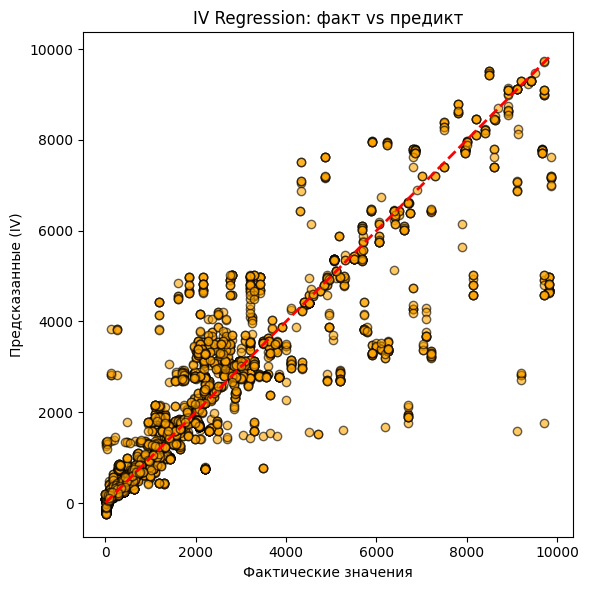

In [70]:
# --- Визуализация "факт vs предикт ---"
plt.figure(figsize=(6, 6))
plt.scatter(y_iv.iloc[:len(y_pred_iv)], y_pred_iv, alpha=0.6, color="orange", edgecolor="k")
plt.plot([y_iv.min(), y_iv.max()], [y_iv.min(), y_iv.max()], "r--", lw=2)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные (IV)")
plt.title("IV Regression: факт vs предикт")
plt.tight_layout()
plt.show()

**Робастные ошибки (HC3)**

In [71]:
robust_model = ols_base.get_robustcov_results(cov_type='HC3')
print(robust_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Цена_pricezpu   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     2188.
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:50:13   Log-Likelihood:                -55592.
No. Observations:                6876   AIC:                         1.112e+05
Df Residuals:                    6864   BIC:                         1.113e+05
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**FEATURE IMPORTANCE**

In [72]:
X = X_train
y = y_train

In [73]:
# --- 1. Микро-подход (добавляем признаки по одному) ---
micro_results = []
features = X.columns.tolist()

for i, feat in enumerate(features, 1):
    X_temp = sm.add_constant(X[[feat]])
    model_temp = sm.OLS(y, X_temp).fit()
    r2 = r2_score(y, model_temp.predict(X_temp))
    micro_results.append((feat, r2))
    print(f"[{i}/{len(features)}] {feat}: R² = {r2:.4f}")

micro_df = pd.DataFrame(micro_results, columns=["Feature", "R2_micro"]).sort_values("R2_micro", ascending=False)

[1/11] Вес штука_pricezpu: R² = 0.5508
[2/11] Количество_pricezpu: R² = 0.0555
[3/11] Количество_pricek: R² = 0.0093
[4/11] Цена_pricek: R² = 0.2348
[5/11] Количество роликов: R² = 0.1374
[6/11] Вес контракт: R² = 0.0089
[7/11] Количество в контракте: R² = 0.0729
[8/11] Цена по ФОБ в долларах: R² = 0.6371
[9/11] Средний курс Юань: R² = 0.0434
[10/11] Средний курс Доллар США: R² = 0.0460
[11/11] Основное обозначение_NEW_te: R² = 0.8466


In [74]:
# --- 2. Макро-подход (убираем признаки по одному) ---
macro_results = []
base_model = sm.OLS(y, sm.add_constant(X)).fit()
base_r2 = r2_score(y, base_model.predict(sm.add_constant(X)))

for i, feat in enumerate(features, 1):
    X_temp = X.drop(columns=[feat])
    model_temp = sm.OLS(y, sm.add_constant(X_temp)).fit()
    r2 = r2_score(y, model_temp.predict(sm.add_constant(X_temp)))
    delta = base_r2 - r2  # падение R² при удалении признака
    macro_results.append((feat, delta))
    print(f"[{i}/{len(features)}] {feat}: ΔR² = {delta:.4f}")

macro_df = pd.DataFrame(macro_results, columns=["Feature", "Delta_R2_macro"]).sort_values("Delta_R2_macro", ascending=False)

[1/11] Вес штука_pricezpu: ΔR² = 0.0003
[2/11] Количество_pricezpu: ΔR² = 0.0001
[3/11] Количество_pricek: ΔR² = 0.0000
[4/11] Цена_pricek: ΔR² = 0.0000
[5/11] Количество роликов: ΔR² = 0.0001
[6/11] Вес контракт: ΔR² = 0.0002
[7/11] Количество в контракте: ΔR² = 0.0000
[8/11] Цена по ФОБ в долларах: ΔR² = 0.0004
[9/11] Средний курс Юань: ΔR² = 0.0001
[10/11] Средний курс Доллар США: ΔR² = 0.0000
[11/11] Основное обозначение_NEW_te: ΔR² = 0.1184


In [75]:
feature_importance = pd.merge(micro_df, macro_df, on="Feature", how="outer")
print("\n=== Итоговая оценка значимости признаков ===")
print(feature_importance.sort_values("Delta_R2_macro", ascending=False).head(15))


=== Итоговая оценка значимости признаков ===
                        Feature  R2_micro  Delta_R2_macro
6   Основное обозначение_NEW_te  0.846633        0.118362
9        Цена по ФОБ в долларах  0.637051        0.000370
1            Вес штука_pricezpu  0.550814        0.000308
0                  Вес контракт  0.008866        0.000174
5           Количество_pricezpu  0.055494        0.000142
8             Средний курс Юань  0.043369        0.000069
3            Количество роликов  0.137421        0.000058
7       Средний курс Доллар США  0.045990        0.000044
10                  Цена_pricek  0.234839        0.000014
2        Количество в контракте  0.072943        0.000007
4             Количество_pricek  0.009292        0.000002


**Общие выводы FEATURE IMPORTANCE**

**1) Главные драйверы цены:**
Цена_pricek;
Цена по FOB в долларах;

**2) Второстепенные, но полезные:**

Количество роликов;
Вес штука_pricezpu

**3) Наименее значимые:**

Количество_pricek, Вес контракт, Количество в контракте — можно рассматривать их как второстепенные.

**Сравнение моделей (OLS, SGD)**

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [77]:
# Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
# OLS
X_test_const = sm.add_constant(X_test, has_constant='add')
X_test_const = X_test_const.loc[:, ~X_test_const.columns.duplicated()]
train_cols = list(dict.fromkeys(ols_base.model.exog_names))
X_test_const = X_test_const.reindex(columns=train_cols, fill_value=0)

y_pred_ols = ols_base.predict(X_test_const)
r2_ols = r2_score(y_test, y_pred_ols)

In [79]:
# SGD с регуляризацией
sgd = SGDRegressor(alpha=0.001, penalty="l2", max_iter=2000, random_state=42)
sgd.fit(X_train_scaled, y_train)
r2_sgd = sgd.score(X_test_scaled, y_test)

In [80]:
print("\n=== Сравнение моделей OLS vs SGD ===")
print("H₀: модели не объясняют вариацию таргета лучше среднего")
print("H₁: модели значимо объясняют вариацию")
print(f"OLS R² = {r2_ols:.3f}")
print(f"SGD R² = {r2_sgd:.3f}")


=== Сравнение моделей OLS vs SGD ===
H₀: модели не объясняют вариацию таргета лучше среднего
H₁: модели значимо объясняют вариацию
OLS R² = 0.870
SGD R² = 0.871


In [81]:
# === Кросс-валидация (5-fold) ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

ols_cv = LinearRegression()
sgd_cv = SGDRegressor(alpha=0.001, penalty="l2", max_iter=2000, random_state=42)

ols_scores = cross_val_score(ols_cv, X_train, y_train, cv=kf, scoring='r2')
sgd_scores = cross_val_score(sgd_cv, X_train_scaled, y_train, cv=kf, scoring='r2')

ols_mean, ols_std = ols_scores.mean(), ols_scores.std()
sgd_mean, sgd_std = sgd_scores.mean(), sgd_scores.std()

print("\n=== Кросс-валидация (5-fold) ===")
print(f"OLS  R² = {ols_mean:.3f} ± {ols_std:.3f}")
print(f"SGD  R² = {sgd_mean:.3f} ± {sgd_std:.3f}")


=== Кросс-валидация (5-fold) ===
OLS  R² = 0.847 ± 0.013
SGD  R² = 0.847 ± 0.013


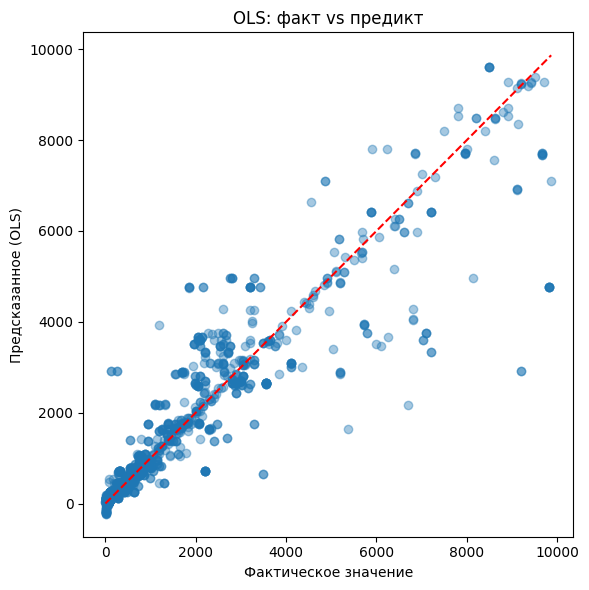

In [82]:
# График факт vs предикт (OLS)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("OLS: факт vs предикт")
plt.xlabel("Фактическое значение")
plt.ylabel("Предсказанное (OLS)")
plt.tight_layout()
plt.show()

**Ансамбли (bagging & boosting)**

In [83]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [84]:
# === 1. Подготовка данных ===
X_cv = X_train.drop(columns=["Цена_pricezpu", "log_target"], errors="ignore")
y_cv = y_train.copy()

In [85]:
# === 2. Инициализация ансамблей ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

models = {"RandomForest": rf, "GradientBoosting": gb}

In [86]:
# === 3. Обучение и тестовые метрики ===
metrics = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # --- Предсказания ---
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # --- Метрики train ---
    r2_train  = r2_score(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100

    # --- Метрики test ---
    r2_test  = r2_score(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    # --- Сохраняем ---
    metrics.append([
        name, r2_train, r2_test, mse_train, mse_test,
        rmse_train, rmse_test, mape_train, mape_test
    ])

    print(f"{name}: R²(train) = {r2_train:.3f}, R²(test) = {r2_test:.3f}")

RandomForest: R²(train) = 0.997, R²(test) = 0.966
GradientBoosting: R²(train) = 0.957, R²(test) = 0.939


In [87]:
# === 4. Таблица результатов ===
metrics_df = pd.DataFrame(metrics, columns=[
    "Model", "R² (train)", "R² (test)",
    "MSE (train)", "MSE (test)",
    "RMSE (train)", "RMSE (test)",
    "MAPE train (%)", "MAPE test (%)"
])

print("\n=== Метрики ансамблей (train/test) ===")
print(metrics_df.round(4))


=== Метрики ансамблей (train/test) ===
              Model  R² (train)  R² (test)  MSE (train)   MSE (test)  \
0      RandomForest      0.9967     0.9664   13516.4854  136361.4865   
1  GradientBoosting      0.9573     0.9391  173037.1630  246692.9318   

   RMSE (train)  RMSE (test)  MAPE train (%)  MAPE test (%)  
0      116.2604     369.2716          4.1575        13.7105  
1      415.9774     496.6819         37.4077        37.8141  


In [88]:
# === 5. Кросс-валидация (5-fold) ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_cv, y_cv, cv=kf, scoring='r2')
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name}  R² = {scores.mean():.3f} ± {scores.std():.3f}")

RandomForest  R² = 0.975 ± 0.007
GradientBoosting  R² = 0.940 ± 0.007


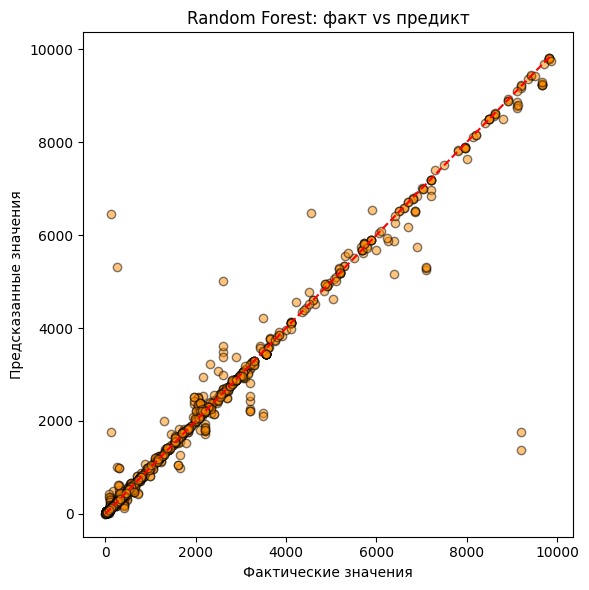

In [90]:
# === 6. Визуализация факт vs предикт (Random Forest) ===
best_model = rf
y_pred_rf = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="#FF8C00", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest: факт vs предикт")
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.tight_layout()
plt.show()

**Нейросеть (перцептрон, PyTorch)**

In [91]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [92]:
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [93]:
# === 3. Определение архитектуры MLP ===
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [94]:
# === 4. Обучение MLP ===
model = MLP(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(100):
    for xb, yb in loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

In [95]:
# === 5. Метрики на train и test ===
model.eval()
with torch.no_grad():
    y_pred_train_nn = model(torch.tensor(X_train.values, dtype=torch.float32)).numpy().ravel()
    y_pred_test_nn = model(torch.tensor(X_test.values, dtype=torch.float32)).numpy().ravel()

In [96]:
# --- Train ---
r2_train_nn  = r2_score(y_train, y_pred_train_nn)
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
rmse_train_nn = np.sqrt(mse_train_nn)
mape_train_nn = mean_absolute_percentage_error(y_train, y_pred_train_nn) * 100

In [97]:
# --- Test ---
r2_test_nn  = r2_score(y_test, y_pred_test_nn)
mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
rmse_test_nn = np.sqrt(mse_test_nn)
mape_test_nn = mean_absolute_percentage_error(y_test, y_pred_test_nn) * 100

In [98]:
# === 6. Результаты ===
print("\n=== PyTorch MLP: метрики (train/test) ===")
print(f"R²(train) = {r2_train_nn:.3f},  R²(test) = {r2_test_nn:.3f}")
print(f"MSE(train) = {mse_train_nn:.2f},  MSE(test) = {mse_test_nn:.2f}")
print(f"RMSE(train) = {rmse_train_nn:.2f}, RMSE(test) = {rmse_test_nn:.2f}")
print(f"MAPE(train) = {mape_train_nn:.2f}%,  MAPE(test) = {mape_test_nn:.2f}%")


=== PyTorch MLP: метрики (train/test) ===
R²(train) = 0.870,  R²(test) = 0.873
MSE(train) = 527698.13,  MSE(test) = 516260.50
RMSE(train) = 726.43, RMSE(test) = 718.51
MAPE(train) = 39.39%,  MAPE(test) = 39.35%


In [99]:
# === 7. Кросс-валидация (5-fold) ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr = torch.tensor(X_train.values[train_idx], dtype=torch.float32)
    y_tr = torch.tensor(y_train.values[train_idx].reshape(-1, 1), dtype=torch.float32)
    X_val = torch.tensor(X_train.values[val_idx], dtype=torch.float32)
    y_val = torch.tensor(y_train.values[val_idx].reshape(-1, 1), dtype=torch.float32)

    model_cv = MLP(X_train.shape[1])
    optimizer = torch.optim.Adam(model_cv.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        optimizer.zero_grad()
        preds = model_cv(X_tr)
        loss = criterion(preds, y_tr)
        loss.backward()
        optimizer.step()

    model_cv.eval()
    with torch.no_grad():
        preds_val = model_cv(X_val).numpy().ravel()
        score = r2_score(y_val.numpy().ravel(), preds_val)
        cv_scores.append(score)

print("\n=== Кросс-валидация (5-fold) для MLP ===")
print(f"R² = {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")


=== Кросс-валидация (5-fold) для MLP ===
R² = 0.595 ± 0.089
